<a href="https://colab.research.google.com/github/AishwaryaKalloli/MIT6x978-homework/blob/main/pset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# b. MNIST Data Loader

In [2]:
device

device(type='cuda')

In [3]:
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


# c. Training Function

In [6]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
      reg = reg_func(output)
    else:
      reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# d. Evaluation Function

In [7]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# **1. AutoEncoder (AE)**

## a. Model


In [29]:
a = [1, 2, 3]
N = len(a)
for x in range(N - 2 , -1 , -1):
  print(a[x])

2
1


In [40]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()

        assert hidden_dims[-1] == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"
        self.encoder = torch.nn.Sequential()
        self.decoder = torch.nn.Sequential()
        # encoder
        last_dim = input_dim
        for i, dim in enumerate(hidden_dims):
            self.encoder.add_module(f"Linear-{i}", torch.nn.Linear(last_dim, dim))
            self.encoder.add_module(f"sigmoid-{i}", torch.nn.Sigmoid())
            last_dim = dim

        # decoder
        last_dim = hidden_dims[-1]
        for i, dim in enumerate(hidden_dims[len(hidden_dims) - 2 :: -1]):
            self.decoder.add_module(f"Linear-{i}", torch.nn.Linear(last_dim, dim))
            self.decoder.add_module(f"sigmoid-{i}", torch.nn.Sigmoid())
            last_dim = dim

        self.decoder.add_module(f"Linear-{i + 1}", torch.nn.Linear(last_dim, input_dim))
        self.decoder.add_module(f"sigmoid-{i + 1}", torch.nn.Sigmoid())

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded}

### Test
hidden_dims = [128, 64, 36, 18, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

ae_test = AE(input_dim, hidden_dims).to(device)
with torch.no_grad():
  test_out = ae_test(test_tensor)


## b. Loss Functions and Optimizers


In [41]:
def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    return mse(reconstructed, x)

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

hidden_dims = [128, 32, 16, 2]

ae = AE(input_dim, hidden_dims).to(device)
print(ae)

optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)


input_dim:  784
AE(
  (encoder): Sequential(
    (Linear-0): Linear(in_features=784, out_features=128, bias=True)
    (sigmoid-0): Sigmoid()
    (Linear-1): Linear(in_features=128, out_features=32, bias=True)
    (sigmoid-1): Sigmoid()
    (Linear-2): Linear(in_features=32, out_features=16, bias=True)
    (sigmoid-2): Sigmoid()
    (Linear-3): Linear(in_features=16, out_features=2, bias=True)
    (sigmoid-3): Sigmoid()
  )
  (decoder): Sequential(
    (Linear-0): Linear(in_features=2, out_features=16, bias=True)
    (sigmoid-0): Sigmoid()
    (Linear-1): Linear(in_features=16, out_features=32, bias=True)
    (sigmoid-1): Sigmoid()
    (Linear-2): Linear(in_features=32, out_features=128, bias=True)
    (sigmoid-2): Sigmoid()
    (Linear-3): Linear(in_features=128, out_features=784, bias=True)
    (sigmoid-3): Sigmoid()
  )
)


## c. Training


In [46]:
optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-1,
                                weight_decay = 1e-8)

In [47]:
################## with Linear, ReLU stacking, but we want sigmoid because these are probabilty values
### Problem 1 (b): Train AE
epochs = 20

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)
##################


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.0277



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0267



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0264



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0261



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0261



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0260



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0260



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0260



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0260



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0259



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0259



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0259



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0259



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0258



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0258



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0258



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0258



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0258



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0258



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0258



## d. Evaluation


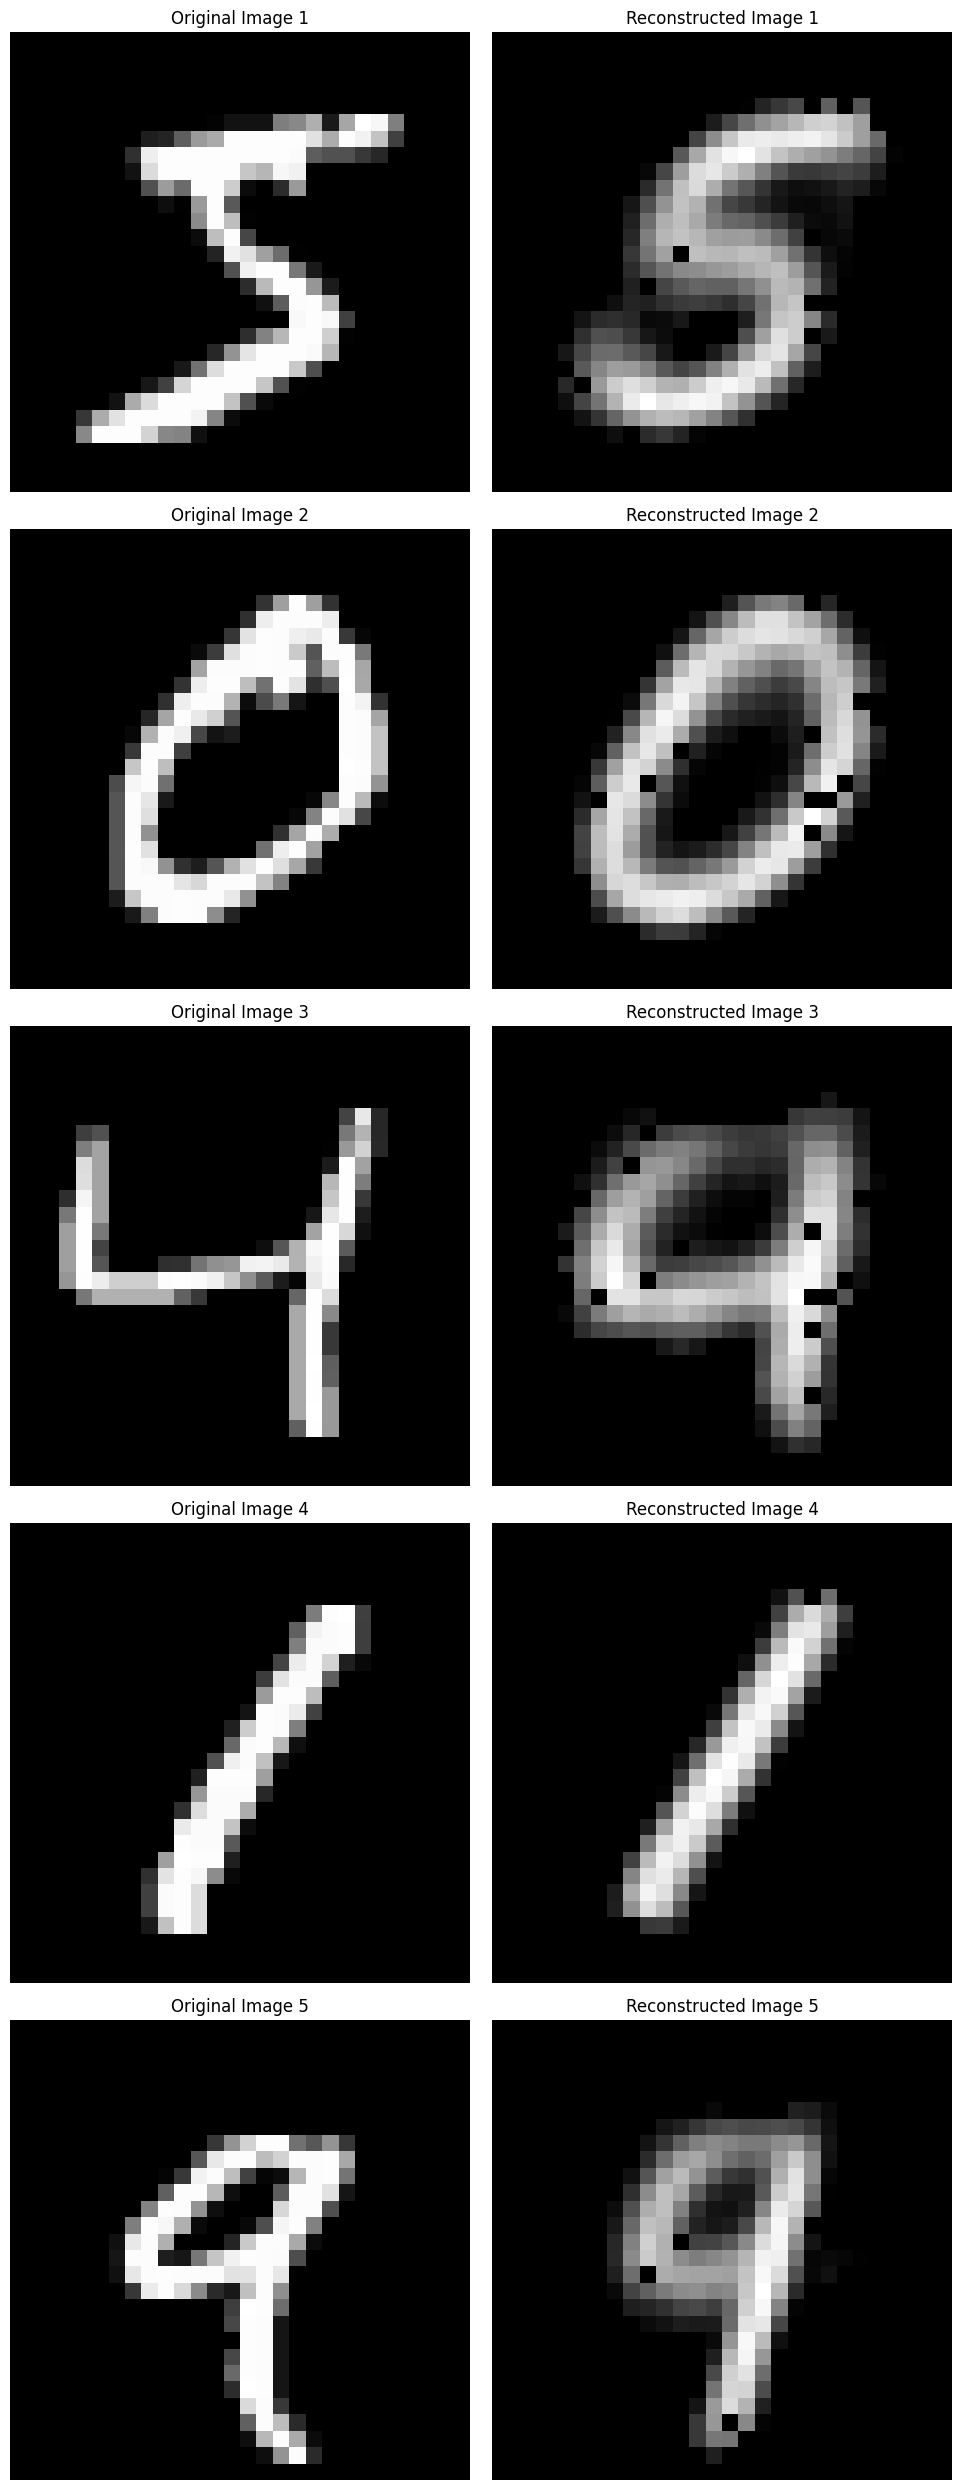

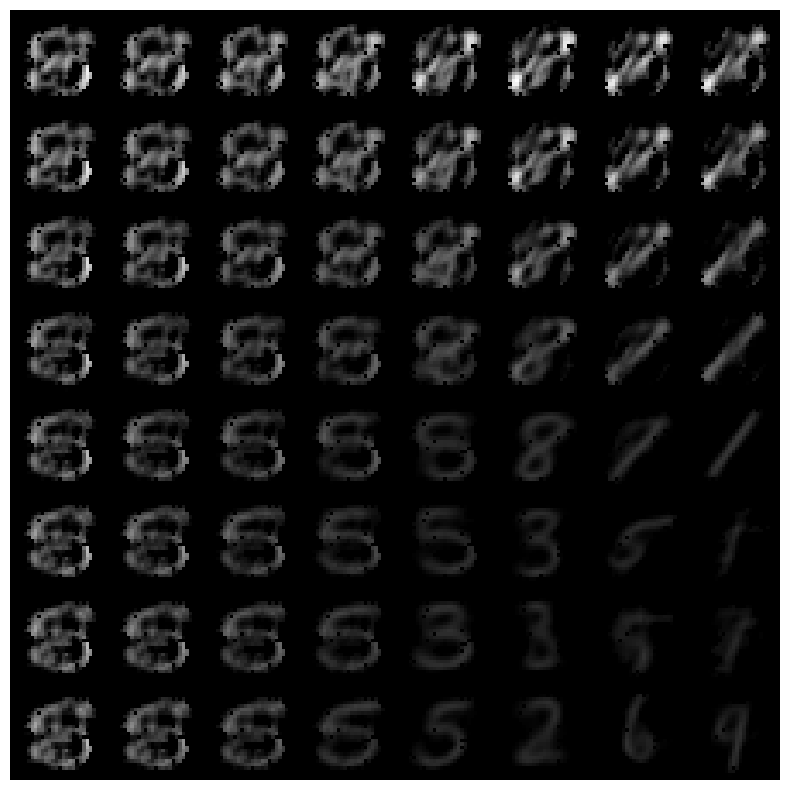

In [39]:
##################
### Problem 1 (b): Evaluate AE
eval(ae)
plot_latent_images(ae, n=8)
##################


# **2. Variational  AutoEncoder (VAE)**
## a. Model

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      self.z_size = hidden_dims[-1] // 2

      self.encoder = torch.nn.Sequential()
      self.decoder = torch.nn.Sequential()
      ##################
      ### Problem 2(b): finish the implementation for encoder and decoder
      ##################

  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      ##################
      ### Problem 2(c): finish the implementation for reparameterization
      ##################
      pass

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
      mean, logvar = self.encode(x)

      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

      z = self.reparameterize(mean, logvar, n_samples_per_z)
      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
      x_probs = torch.mean(x_probs, dim=[1])

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = vae_test(test_tensor)


## b. Loss Functions

### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log\frac{p(x, z)}{q(z|x)}] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

In practice, the above expectation is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i, j} [\log p(x_i|z_{i, j}) + \log p(z_{i, j}) - \log q(z_{i, j}|x_i)], $$
where $z_{i, j}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$. In this assignment, we only sample one $z_{i,j}$ for each $x_i$ (see the function ``reparameterize()`` in the ``VAE()`` class).

In [ ]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################
    pass

def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return logpz -logqz_x


### Loss 2: KL Divergence w/o Estimation
In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In the assignment, you derived the cases where the ELBO can be expressed as an analytical KL-divergence plus the expected reconstruction error, specifically when both $q(z|x)$ and $p(z)$ are Gaussian distributions:
$$\mathrm{ELBO} ≈ -D_{KL}(q(z|x) || p(z)) + \sum_{i, j} \log p(x_i|z_{i, j}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i, j} \log p(x_i|z_{i, j})$$

In [ ]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return -0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


## c. Verifying loss 1 == loss 2


In [ ]:
##################
### Problem 3(b): Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [128, 32, 16, 4]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))

with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
##################


## d. Training with ELBO loss



In [ ]:
##################
### Problem 3(c): Train VAE with ELBO loss
epochs = 20

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

coeff = 1e-3

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=1e-3), optimizer_vae_sgvb, epochs)
##################


## e. Evaluation

In [ ]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


## f. Training with KL Divergence w/o Estimation

In [ ]:
##################
### Problem 3(c): Train VAE with analytical KL
epochs = 20

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1e-3), optimizer_vae_kl_wo_e, epochs)
##################


## g. Evaluation

In [ ]:
##################
### Problem 3(c): Evaluate VAE with analytical KL
eval(vae_kl_wo_e)
plot_latent_images(vae_kl_wo_e, n=8)
##################


# **3. Torus**

## a. Data Generation

In [ ]:
def generate_torus_point_cloud(R, r, num_points=1000, seed=1234):
    """
    Parameters:
    - R: Major radius of the torus (distance from the center of the tube to the center of the torus).
    - r: Minor radius of the torus (radius of the tube).
    - num_points: Number of points to sample in the point cloud.

    Returns:
    - x, y, z: Arrays containing the x, y, and z coordinates of the sampled points.
    """
    np.random.seed(seed)
    u = np.random.uniform(0, 2 * np.pi, num_points)
    np.random.seed(seed+1)
    v = np.random.uniform(0, 2 * np.pi, num_points)

    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)

    points = np.vstack((x, y, z)).T

    return points

def plot_torus_point_cloud(x, y, z, ax, color='b', name='Training Data'):
    """
    Plots the 3D point cloud of a torus.
    """
    ax.scatter(x, y, z, c=color, marker='o', s=5)

    # Set equal scaling for all axes
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(name)
    return ax

class TorusPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, R, r, num_points=1000):
        """
        Args:
            R (float): Major radius of the torus.
            r (float): Minor radius of the torus.
            num_points (int): Number of points to generate.
        """
        points = generate_torus_point_cloud(R, r, num_points)
        self.points = torch.tensor(points, dtype=torch.float32)

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx], 0 # dummy label

R = 1.0
r = 0.5
num_points = 3000

torus_pc_dataset = TorusPointCloudDataset(R, r, num_points)
torus_pc_dataloader = torch.utils.data.DataLoader(torus_pc_dataset, batch_size=3000, shuffle=True)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(torus_pc_dataset.points[:, 0], torus_pc_dataset.points[:, 1], torus_pc_dataset.points[:, 2], ax)
plt.show()


## b. Network Architecture

In [ ]:
class PositionalEncoding3D(torch.nn.Module):
    def __init__(self, num_frequencies=10):
        """
        Initializes the positional encoding for 3D coordinates.

        Args:
            num_frequencies (int): The number of different frequencies to use for encoding.
        """
        super().__init__()
        self.num_frequencies = num_frequencies
        self.frequencies = 2 ** torch.arange(num_frequencies, dtype=torch.float32)

    def forward(self, points):
        """
        Applies positional encoding to the 3D points.

        Args:
            points (torch.Tensor): N x 3 tensor of 3D coordinates.

        Returns:
            torch.Tensor: N x (6*num_frequencies) tensor of encoded coordinates.
        """
        encoded_points = []
        for i in range(points.shape[1]):  # For each dimension (x, y, z)
            for freq in self.frequencies:
                encoded_points.append(torch.sin(freq * points[:, i:i+1]))
                encoded_points.append(torch.cos(freq * points[:, i:i+1]))
        return torch.cat(encoded_points, dim=-1)

###############
### Problem 4(c): Create your own VAE
###############

class PointVAE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()

        self.pos_enc = PositionalEncoding3D()
        #############
        ### Problem 4(c): Create your own VAE
        self.vae = VAE(input_dim=self.pos_enc.num_frequencies * 6, hidden_dims=hidden_dims, decode_dim=3, use_sigmoid=False)
        #############

    def forward(self, x):
        emb = self.pos_enc(x)
        return self.vae(emb)


## c. Training

In [ ]:
#############
### Problem 4(a): Train VAE on torus data
epochs = 1000

hidden_dims = [32, 16, 8] # -> 2/3 dim

point_vae = PointVAE(hidden_dims).to(device)
print(point_vae)

optimizer_point_vae = torch.optim.Adam(point_vae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_point_vae = train(torus_pc_dataloader, point_vae, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=0.0), optimizer_point_vae, epochs)
#############


## d. Evaluation on Reconstruction

In [ ]:
#############
### Problem 4(a): Evaluation on reconstruction
with torch.no_grad():
  output = point_vae(torus_pc_dataset.points.to(device))
  decoded_pc = output['imgs'].cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
#############


## e. Evaluation on Interpolation

In [ ]:
#############
### Problem 4(v): Evaluation on linear interpolation
z0 = point_vae(torch.tensor([[0.0, 1.0, 0.]]).to(device))['z']
z1 = point_vae(torch.tensor([[0.0, -1.0, 0.]]).to(device))['z']

print(hidden_dims[-1])
num_steps = 100

weights = torch.linspace(0, 1, num_steps).view(-1, 1).to(device)
latent_vecs = weights * z0 + (1 - weights) * z1

with torch.no_grad():
    outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))

lin_traj = outputs.cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(lin_traj[:, 0], lin_traj[:, 1], lin_traj[:, 2], ax, color='r', name="Decoded Data")
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
plt.show()
#############
